In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,0.0,0.0,18.733,18.733,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.0,0.0,37.465,18.733,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-24,12.0,8.0,0.0,0.0,112.395,74.930,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
36344,NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36345,NaN,NaN,International,2020-03-02,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36346,NaN,NaN,International,2020-03-10,696.0,-9.0,7.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


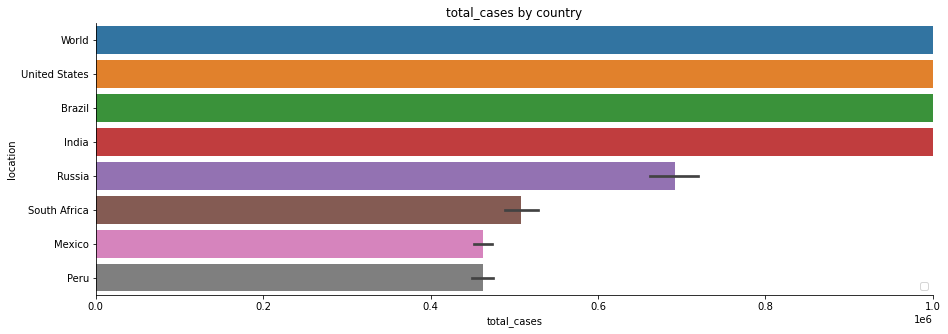

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


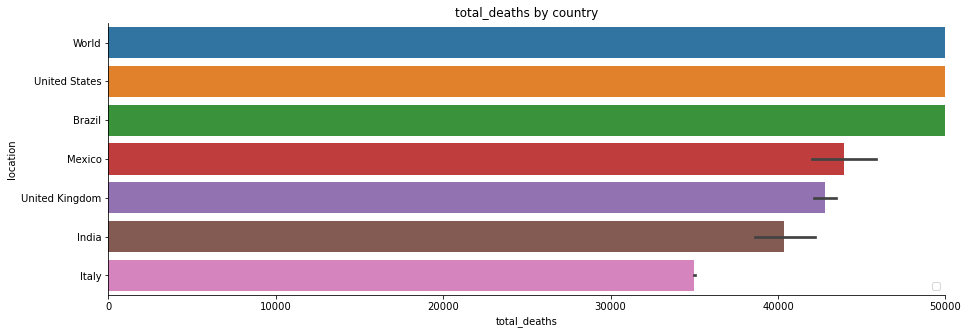

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


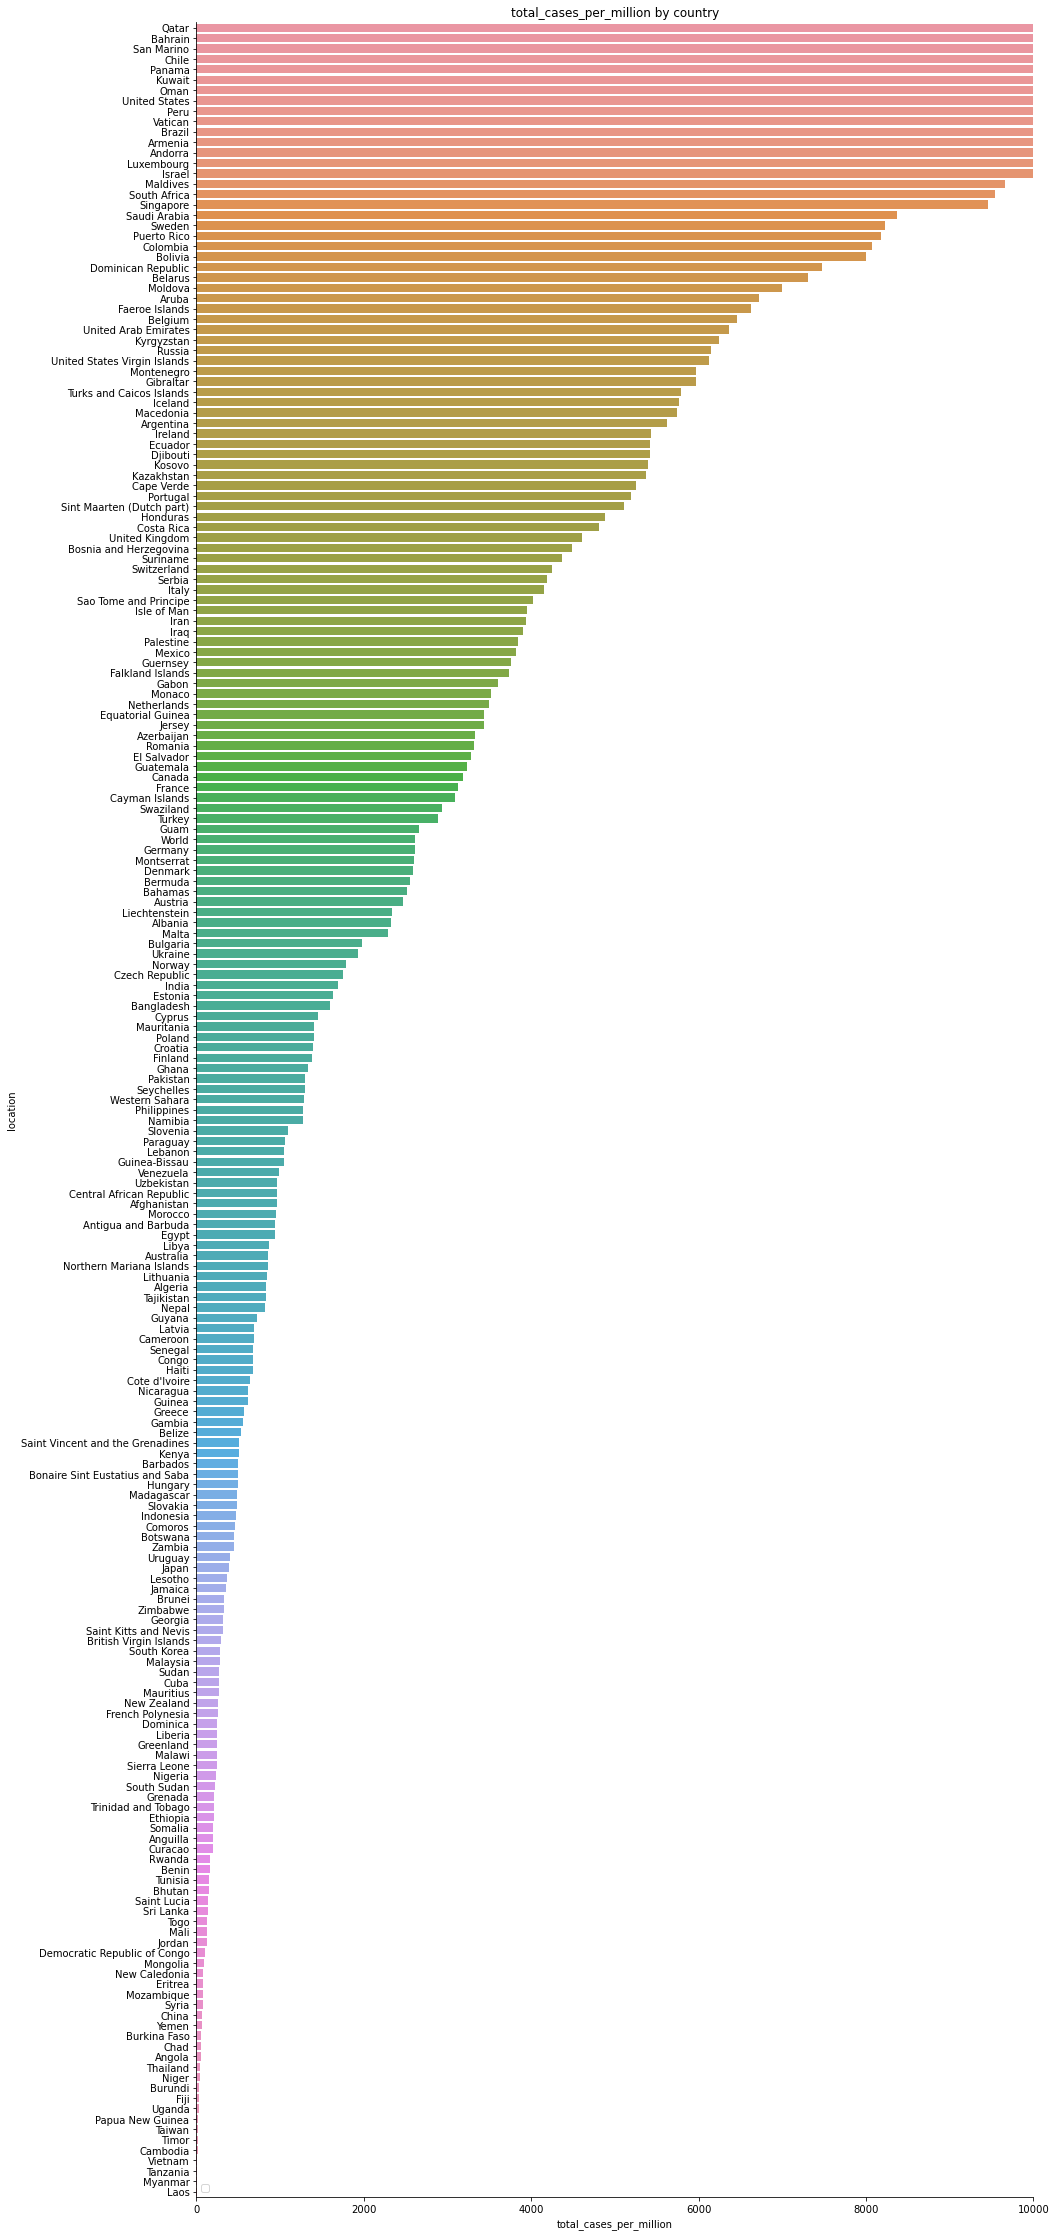

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


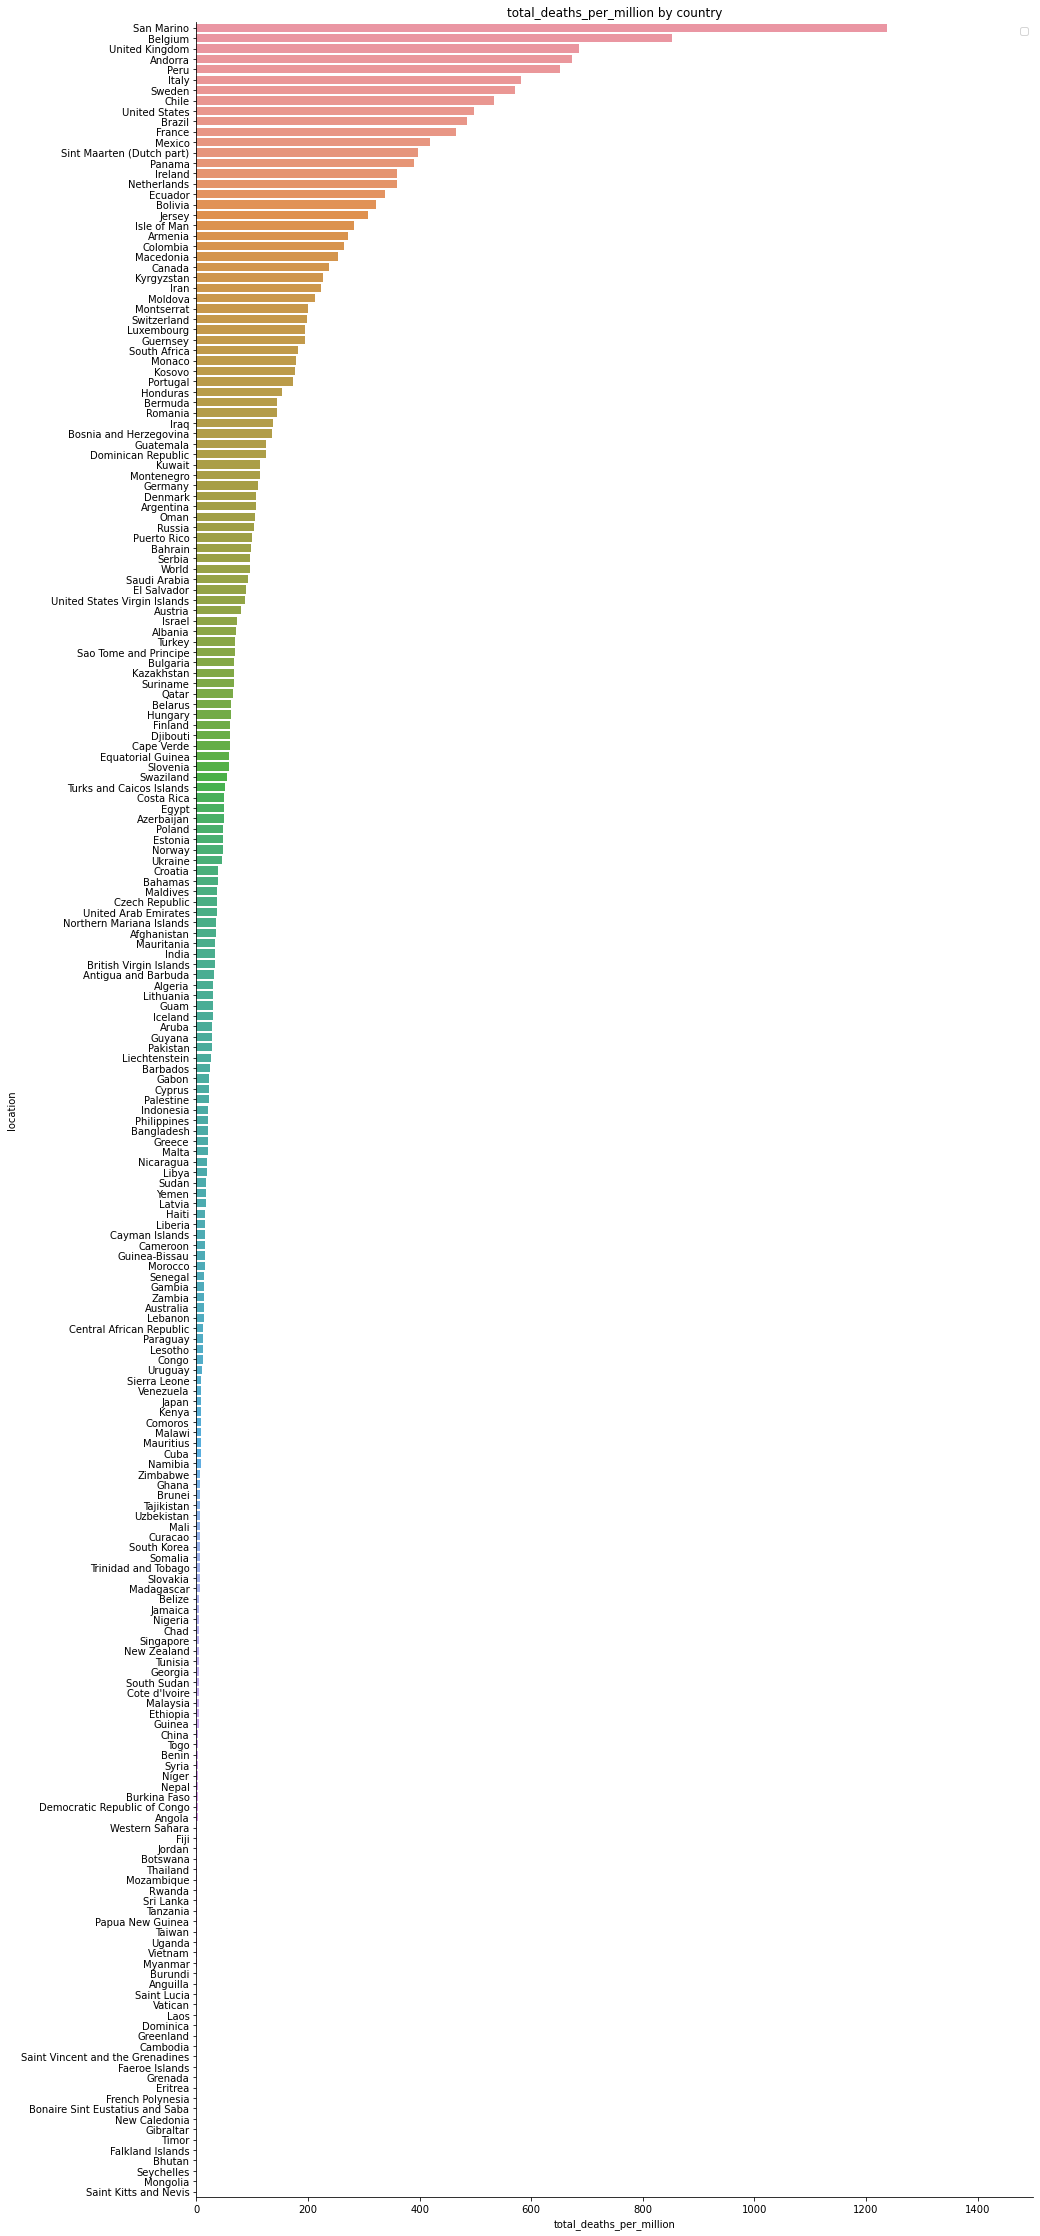

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

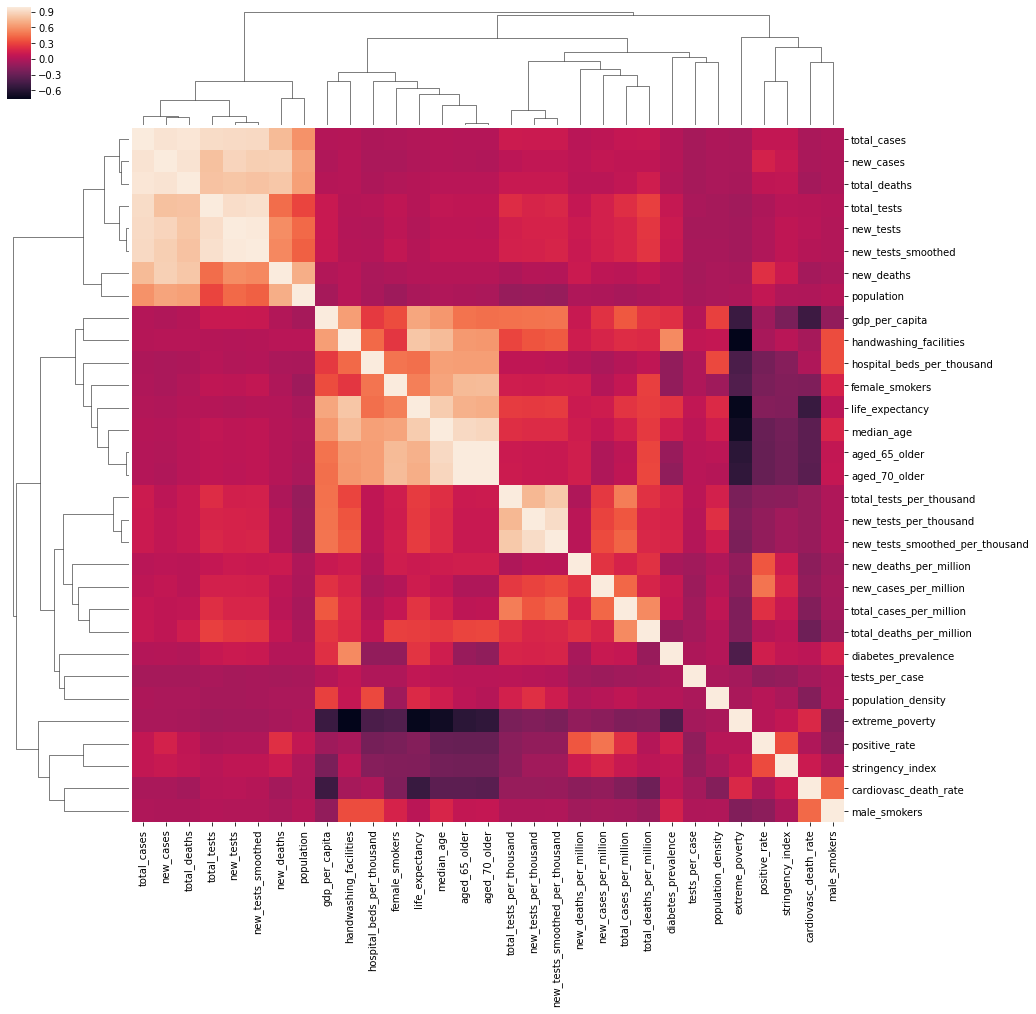

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.999641332707924 (+/- 0.0002164605385060141)
Coef :  [1.04437766e+00 8.34293888e-05 9.09508717e-05]
3 Last_days :  [[19855127 20074672 20330351]]
Today :  20330351
Prediction + :  471329
Tomorow :  20801680
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995724404386932 (+/- 2.1713321938471314e-05)
Coef :  [-0.15018264  0.56000865  0.59952772]
3 Last_days :  [[731330 736310 742413]]
Today :  742413
Prediction + :  7156
Tomorow :  749569
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9780086972803511 (+/- 0.019862772320380088)
Coef :  [-0.67304079  0.73169727  0.94191893]
3 Last_days :  [[197921 202775 204172]]
Today :  204172
Prediction + :  3622
Tomorow :  207794
                                     
--------- Total Death -----------------
                                     
R^2: 0.42540650965255794 (+/- 0.7911629653748534)
Coef :  [-0.75668797  0.78813903  0.96771656]
3 Last_days :  [[30324 30340 30354]]
Today :  30354
Prediction + :  36
Tomorow :  30390
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7122461433964448 (+/- 0.22900081449368992)
Coef :  [-0.32012012 -0.02800904  1.34239736]
3 Last_days :  [[88793 88906 88964]]
Today :  88964
Prediction + :  75
Tomorow :  89039
                                     
--------- Total Death -----------------
                                     
R^2: -1566.4201508567069 (+/- 2216.1569909565164)
Coef :  [-0.07640081  0.01240599  1.0561099 ]
3 Last_days :  [[4686 4690 4693]]
Today :  4693
Prediction + :  7
Tomorow :  4700
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7774465690367186 (+/- 0.3125413570626105)
Coef :  [-0.84121687  0.90669314  0.93373175]
3 Last_days :  [[250566 250825 251237]]
Today :  251237
Prediction + :  354
Tomorow :  251591
                                     
--------- Total Death -----------------
                                     
R^2: 0.9494650391939228 (+/- 0.053306626218931494)
Coef :  [-0.83935149  0.90534741  0.93324115]
3 Last_days :  [[35205 35209 35215]]
Today :  35215
Prediction + :  26
Tomorow :  35241
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6117911397877037 (+/- 0.5357182687691462)
Coef :  [-0.75231837  0.78027556  0.97241149]
3 Last_days :  [[314362 322980 326612]]
Today :  326612
Prediction + :  6896
Tomorow :  333508
                                     
--------- Total Death -----------------
                                     
R^2: -0.054616203051336076 (+/- 0.7469779987526957)
Coef :  [-0.71344342  0.60046288  1.11201367]
3 Last_days :  [[28503 28576 28581]]
Today :  28581
Prediction + :  62
Tomorow :  28643
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9965328016952913 (+/- 0.004331095195357559)
Coef :  [0.06905876 0.47001072 0.48199057]
3 Last_days :  [[5044864 5094394 5141207]]
Today :  5141207
Prediction + :  89111
Tomorow :  5230318
                                     
--------- Total Death -----------------
                                     
R^2: 0.4964099943042644 (+/- 0.7071270257845481)
Coef :  [-0.67236328  0.78562401  0.88861204]
3 Last_days :  [[162938 163461 164537]]
Today :  164537
Prediction + :  757
Tomorow :  165294
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9963581455951336 (+/- 0.003557424429831304)
Coef :  [-0.78967247  0.88078895  0.90898281]
3 Last_days :  [[310825 311641 312789]]
Today :  312789
Prediction + :  986
Tomorow :  313775
                                     
--------- Total Death -----------------
                                     
R^2: 0.46762114681306716 (+/- 0.7463906210134437)
Coef :  [-0.76429436  0.83004867  0.93411159]
3 Last_days :  [[46574 46526 46526]]
Today :  46526
Prediction + :  22
Tomorow :  46548
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9929990299758624 (+/- 0.008004307980085942)
Coef :  [-0.81866962  0.86920442  0.94897965]
3 Last_days :  [[216327 217293 218519]]
Today :  218519
Prediction + :  909
Tomorow :  219428
                                     
--------- Total Death -----------------
                                     
R^2: 0.4556058526608385 (+/- 0.7520569300553266)
Coef :  [-0.79981707  0.84324065  0.95603159]
3 Last_days :  [[9197 9201 9207]]
Today :  9207
Prediction + :  10
Tomorow :  9217
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.434393319963638 (+/- 0.7994719082267671)
Coef :  [0.11972785 0.44673372 0.44670374]
3 Last_days :  [[326712 328844 331189]]
Today :  331189
Prediction + :  3872
Tomorow :  335061
                                     
--------- Total Death -----------------
                                     
R^2: 0.8867251023570395 (+/- 0.15982870125642776)
Coef :  [-0.11897822  0.56935392  0.56330588]
3 Last_days :  [[18427 18616 18800]]
Today :  18800
Prediction + :  231
Tomorow :  19031
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9987707494852925 (+/- 0.0014947083642289118)
Coef :  [-0.76980875  0.86296924  0.90399318]
3 Last_days :  [[240804 241997 243180]]
Today :  243180
Prediction + :  1059
Tomorow :  244239
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995670856123554 (+/- 0.0003294144069539699)
Coef :  [-0.83012039  0.90404322  0.92308011]
3 Last_days :  [[5844 5858 5873]]
Today :  5873
Prediction + :  13
Tomorow :  5886
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.47022594845999527 (+/- 0.7472231928383954)
Coef :  [-0.22440295  0.48982575  0.75272997]
3 Last_days :  [[3035422 3057470 3109630]]
Today :  3109630
Prediction + :  51608
Tomorow :  3161238
                                     
--------- Total Death -----------------
                                     
R^2: 0.5116585188593074 (+/- 0.6860387121052554)
Coef :  [-0.26008803  0.57258436  0.70045647]
3 Last_days :  [[101049 101752 103026]]
Today :  103026
Prediction + :  1299
Tomorow :  104325
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(20330351, 742413, 20801680, 749569),
 (204172, 30354, 207794, 30390),
 (251237, 35215, 251591, 35241),
 (326612, 28581, 333508, 28643),
 (5141207, 164537, 5230318, 165294),
 (88964, 4693, 89039, 4700),
 (312789, 46526, 313775, 46548),
 (218519, 9207, 219428, 9217),
 (331189, 18800, 335061, 19031),
 (243180, 5873, 244239, 5886),
 (3109630, 103026, 3161238, 104325)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-12,France,207794.0,0.0,30390.0,0.0,0.0,0.0
0,2020-08-12,China,89039.0,0.0,4700.0,0.0,0.0,0.0
0,2020-08-12,Italy,251591.0,0.0,35241.0,0.0,0.0,0.0
0,2020-08-12,Spain,333508.0,0.0,28643.0,0.0,0.0,0.0
0,2020-08-12,United States,5230318.0,0.0,165294.0,0.0,0.0,0.0
0,2020-08-12,World,20801680.0,0.0,749569.0,0.0,0.0,0.0
0,2020-08-12,United Kingdom,313775.0,0.0,46548.0,0.0,0.0,0.0
0,2020-08-12,Germany,219428.0,0.0,9217.0,0.0,0.0,0.0
0,2020-08-12,Iran,335061.0,0.0,19031.0,0.0,0.0,0.0
0,2020-08-12,Turkey,244239.0,0.0,5886.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")